In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
from keras import layers, backend
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras import utils as np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform 
import scipy.misc
from matplotlib.pyplot import imshow
from keras.initializers import glorot_uniform
from tensorflow import keras
from keras.applications import imagenet_utils
import tensorflow as tf
from __future__ import print_function
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
from functools import reduce
from PIL import Image, ImageStat
import os
import cv2

In [ ]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.layers import Layer, InputSpec

In [ ]:
def Otsus_Binarization(folder,target):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),0)
        #ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        if img is not None:
            images.append([img,target])
    return images

In [ ]:
tubercolosis = Otsus_Binarization('/content/drive/MyDrive/tuber_images/Normal/',0)

In [ ]:
tb = Otsus_Binarization('/content/drive/MyDrive/tuber_images/Tuberculosis',1)

In [ ]:
tubercolosis.extend(tb)

In [ ]:
TOTAL_DATA = tubercolosis

In [ ]:
FEATURE_MATRIX = []
TARGET=[]
for x,y in TOTAL_DATA:
    FEATURE_MATRIX.append(x)
    TARGET.append(y)

In [ ]:
X=[]
IMG_SIZE= 224
for x in FEATURE_MATRIX:
    new_array = cv2.resize(x,(IMG_SIZE,IMG_SIZE))
    X.append(new_array)

In [ ]:
NORMALIZED_X = []
for x in X:
    tmp = x/255
    NORMALIZED_X.append(tmp)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(NORMALIZED_X,TARGET)

In [ ]:
print(np.array(x_train).shape)
print(np.array(x_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(3210, 224, 224)
(1070, 224, 224)
(3210,)
(1070,)


In [ ]:
img_rows=x_train[0].shape[0]
img_cols=x_train[0].shape[1]
print(img_rows)
print(img_cols)

224
224


In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [ ]:
##in crease 1 dimension
X_train=x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
X_test=x_test.reshape(x_test.shape[0],img_rows,img_cols,1)

In [ ]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(3210, 224, 224, 1)
(1070, 224, 224, 1)
(3210,)
(1070,)


In [ ]:
def identity_block(X, f, filters):
  #retrive filters
  F1, F2, F3 = filters

  X_shortcut = X


#first layer
  X= Conv2D(filters = F1, kernel_size=(1,1), strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)
  X= Activation('relu')(X)

  #second layer
  X= Conv2D(filters = F2, kernel_size=(f,f), strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)
  X= Activation('relu')(X)

  #third layer
  X= Conv2D(filters = F3, kernel_size=(1,1),strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)


  #final step: adding shoetcut value to F(x), and pass it through Relu activation
  X= Add()([X, X_shortcut])
  X= Activation('relu')(X)

  return X
           
  

In [ ]:
def convolution_block(X, f, filters, s=2):
  #retrive filters
  F1, F2, F3 = filters
#saving the input value
  X_shortcut = X

#first layer
  X= Conv2D(F1, (1,1), strides = (s,s))(X) #1,1 is a filter size
  X= BatchNormalization(axis=3)(X)
  X= Activation('relu')(X)

#second layer (f,f)=3*3 filter by default
  X= Conv2D(filters = F2, kernel_size=(f,f), strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)
  X= Activation('relu')(X)

#third layer
  X= Conv2D(filters = F3, kernel_size=(1,1),strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)

#shortcutpath
  X_shortcut= Conv2D(filters = F3, kernel_size=(1,1),strides = (s,s), padding = 'same')(X_shortcut)
  X_shortcut= BatchNormalization(axis=3)(X_shortcut)


  #final step: adding shoetcut value to F(x), and pass it through Relu activation
  X= Add()([X, X_shortcut])
  X= Activation('relu')(X)


  return X
  

In [ ]:
#from keras.engine.input_layer import InputLayer
def ResNet50(input_shape=(224,224), classes=2):

  
  #defining the input with shape input_shape
  X_input = Input(input_shape)
  #keras.layers.Input(input_shape=(224, 224, 3))
  #zero padding
  x = ZeroPadding2D((3,3))( X_input) #3,3 padding

  #stage1
  x= Conv2D(64,(7,7), strides = (2,2))(x) #1,1 is a filter size
  x= BatchNormalization(axis=3)(x)
  x= Activation('relu')(x)
  x= MaxPooling2D((3,3), strides=(2,2))(x)


#second layer
  x = convolution_block(x, f=3, filters=[64,64,256], s=1)
  x = identity_block(x, 3, [64,64,256])
  x = identity_block(x, 3, [64,64,256])

#third stage
  x = convolution_block(x, f=3, filters=[128,128,512], s=2)
  x = identity_block(x, 3, [128,128,512])
  x = identity_block(x, 3, [128,128,512])  
  x = identity_block(x, 3, [128,128,512])

#fourth stage
  x = convolution_block(x, f=3, filters=[256,256,1024], s=2)
  x = identity_block(x, 3, [256,256,1024])
  x = identity_block(x, 3, [256,256,1024])  
  x = identity_block(x, 3, [256,256,1024])
  x = identity_block(x, 3, [256,256,1024])
  x = identity_block(x, 3, [256,256,1024])

#fifth stage
  x = convolution_block(x, f=3, filters=[512,512,2048], s=2)
  x = identity_block(x, 3, [512,512,2048])
  x = identity_block(x, 3, [512,512,2048])

#average pool
  x = AveragePooling2D((2,2),name="avg_pool")(x)

#output layer
  x = Flatten()(x)
  x = Dense(classes, activation='softmax',name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=42))(x)

#creating a model
  model = Model(inputs = X_input, outputs=x, name='ResNet50')

  return model






In [ ]:
model = ResNet50(input_shape=(224,224,1), classes=2)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(np.array(x_train),np.array(y_train), epochs=20,validation_data=(x_test, np.array(y_test)))

Epoch 1/20
101/101 [==============================] - 227s 2s/step - loss: 0.7779 - accuracy: 0.8975 - val_loss: 0.4775 - val_accuracy: 0.8206
Epoch 2/20
101/101 [==============================] - 227s 2s/step - loss: 0.0986 - accuracy: 0.9645 - val_loss: 1.3076 - val_accuracy: 0.3215
Epoch 3/20
101/101 [==============================] - 219s 2s/step - loss: 0.0618 - accuracy: 0.9807 - val_loss: 3.5407 - val_accuracy: 0.1869
Epoch 4/20
101/101 [==============================] - 242s 2s/step - loss: 0.0488 - accuracy: 0.9850 - val_loss: 2.7131 - val_accuracy: 0.2065
Epoch 5/20
101/101 [==============================] - 260s 3s/step - loss: 0.0403 - accuracy: 0.9860 - val_loss: 0.2191 - val_accuracy: 0.9411
Epoch 6/20
101/101 [==============================] - 252s 2s/step - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.3835 - val_accuracy: 0.8477
Epoch 7/20
101/101 [==============================] - 239s 2s/step - loss: 0.0631 - accuracy: 0.9798 - val_loss: 0.4079 - val_accuracy: 0.8421

In [ ]:
predicted = model.predict(np.array(X_test))

In [ ]:
predicted

In [ ]:
result = []
for item in predicted:
    result.append(np.argmax(item))

In [ ]:
print(result)

[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 

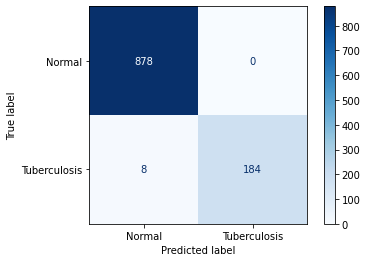

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,result)
labels = ["Normal","Tuberculosis"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()